In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.patches import Circle

import warnings
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve,roc_auc_score,f1_score,accuracy_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

In [2]:
warnings.filterwarnings(action = 'ignore')

In [3]:
rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

# Classifier 문제 Ensemble Bagging 

### Classifier 문제에서 앙상블이 효과적인 이유 

##### 1. 과적합 감소
* 단일 모델이 학습 데이터에서는 잘 작동하지만, 새로운 데이터에서는 효과적이지 못해 과적합 문제가 발생한 경우 앙상블 모델이 효과적이다. 개별 모델 마다 고유한 강점과 약점이 있는 부분을 결합함으로써 더 넓은 범위의 패턴을 포착하고 더 정확한 예측을 할 수 있음 

##### 2. 모델의 불확실성 처리 
* 단일 모델의 정량화 된 신뢰성 (Loss, accuracy .. etc )을 통해 모델 별 상대적 중요성을 고려 할 수 있음. 이는 앙상블 이외에도 다양한 응용 프로그램에서도 유용 할 수 있음 

##### 3. 유연성 및 적응성
* 다양한 유형의 데이터 및 문제 도메인에 유연하고 적응 할 수 있음 , 특정 요구 사항에 맞게 사용자가 정의 할 수 있기에 쉽게 확장하거나 새로운 모델을 추가로 사용 할 수 있음 

### 요약하자면, 앙상블 모델은 개별 모델의 집단 지식, 강점 및 관점을 활용하여 정확도, 견고성 및 일반화가 향상됨 


# 예제 데이터 생성

In [4]:
X, y = make_classification(n_samples = 1000, n_features=2, n_informative=2, n_redundant=0, n_classes=2,
                            random_state = 55, flip_y = 0.3) #flip_y 로 noise 생성 

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

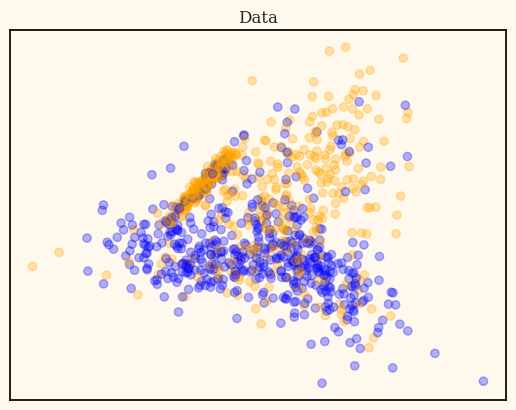

In [5]:
cmap = ['orange' if label == 1 else 'blue' for label in y]

plt.scatter(X[:,0], X[:,1], c = cmap, alpha = 0.3)
plt.title('Data')
plt.axis()
plt.xticks([])
plt.yticks([]);

# 단일 모델 생성 

In [6]:
rf = RandomForestClassifier(n_estimators = 10, random_state = 42)
xgb = XGBClassifier(n_estimators = 10, random_state = 42)
lgb = LGBMClassifier(n_estimators = 10, verbose = -1, random_state = 42)
svc = SVC(probability = True)
logist = LogisticRegression(C = 1)
knn = KNeighborsClassifier()

models = [rf,xgb,lgb,svc,logist,knn]

models_name = ['RandomForestClassifier', 'XGBClassifier', 'LGBMClassifier',
                'SVC','LogisticRegression', 'KNeighborsClassifier']

In [7]:
def train_test_score(model, train_x,train_y,test_x,test_y):
    
    model.fit(train_x,train_y)
    train_pred = model.predict(train_x)
    test_pred = model.predict(test_x)
    
    train_score = round(accuracy_score(train_y, train_pred),2)
    test_score = round(accuracy_score(test_y, test_pred),2)
    
    return train_score,test_score

# 단일 모델 별 예측 성능 및 Decision region 비교 

Text(0.5, 0.98, 'Train Classifier rigion')

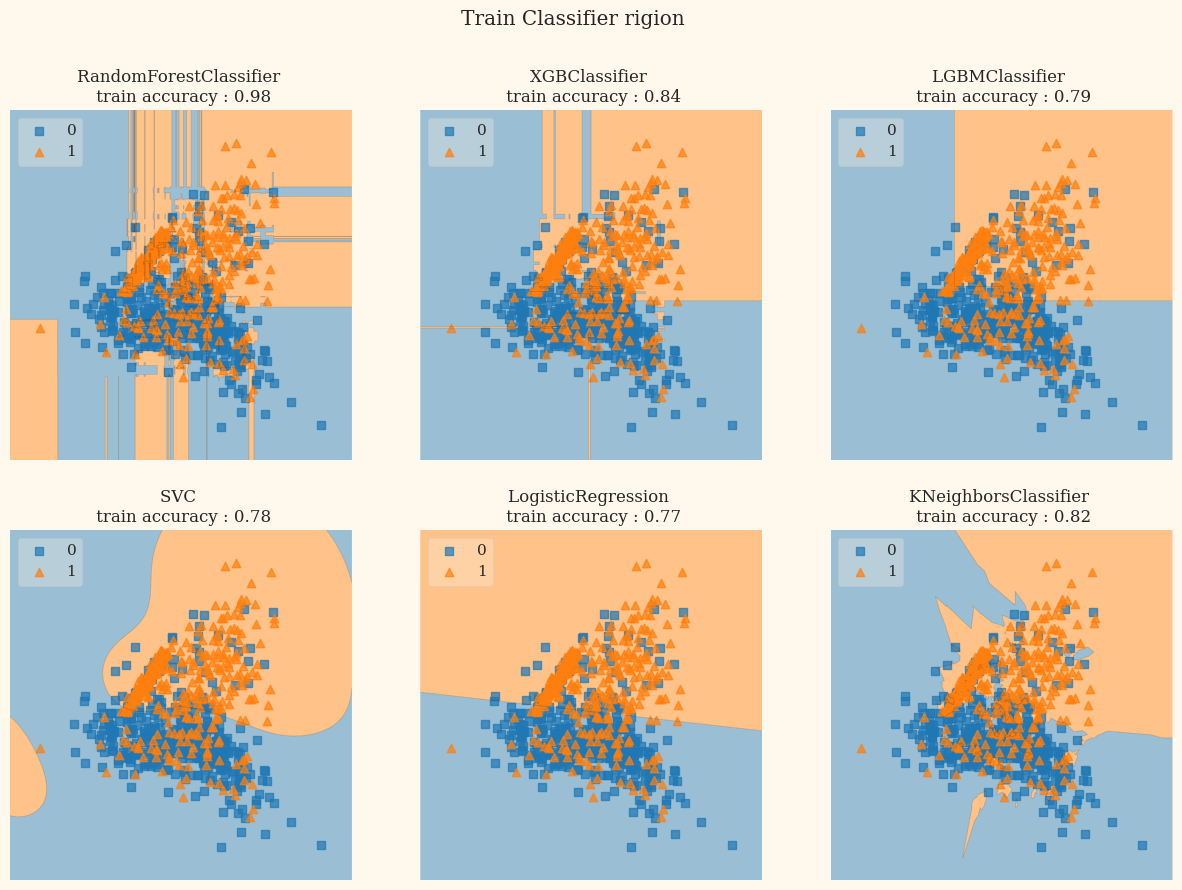

In [8]:
fig,ax = plt.subplots(ncols = 3, nrows = 2, figsize = (15,10))
ax = ax.flatten()

scatter_kwargs = {'edgecolor': None, 'alpha': 0.7}
contourf_kwargs = {'alpha': 0.2}


for i,model in enumerate(models):
    
    train_score,test_score = train_test_score(model,x_train,y_train,x_test,y_test)
    
    plot_decision_regions(x_train,y_train,clf = model,
                            legend = 2,
                            scatter_kwargs = scatter_kwargs,
                            contour_kwargs = contourf_kwargs,
                            ax = ax[i])
    
    ax[i].set_title(f'{models_name[i]} \n train accuracy : {train_score}')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
fig.suptitle('Train Classifier rigion')

Text(0.5, 0.98, 'Test Classifier rigion')

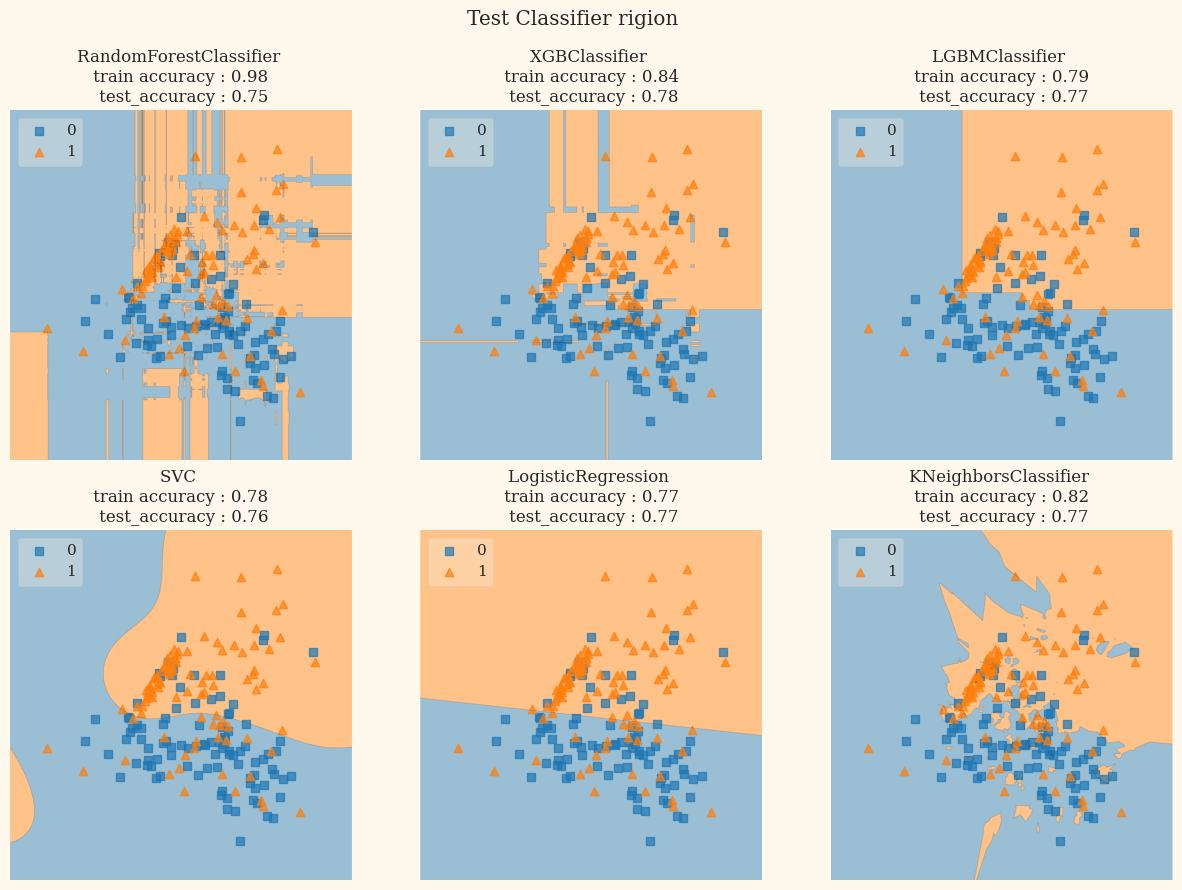

In [9]:
fig,ax = plt.subplots(ncols = 3, nrows = 2, figsize = (15,10))
ax = ax.flatten()


scatter_kwargs = {'edgecolor': None, 'alpha': 0.7}
contourf_kwargs = {'alpha': 0.2}


for i,model in enumerate(models):
    
    train_score,test_score = train_test_score(model,x_train,y_train,x_test,y_test)
    
    plot_decision_regions(x_test,y_test,clf = model,
                            legend = 2,
                            scatter_kwargs = scatter_kwargs,
                            contour_kwargs = contourf_kwargs,
                            ax = ax[i])
    
    ax[i].set_title(f'{models_name[i]} \n train accuracy : {train_score} \n test_accuracy : {test_score}')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
fig.suptitle('Test Classifier rigion')

# Simple Ensemble 

##### model 별 가중치를 두지 않고 단순 평균으로 앙상블 

In [10]:
class SimpleEnsembleModel:
    
    def __init__(self,models, method):
        
        self.models = models
        self.fitted_models = []
        self.method = method
        
    def fit(self,X,y):
        
        self.X = X
        self.y = y
        
        self.fitted_models = [model.fit(self.X,self.y) for model in self.models]
        
    def predict(self,test):
            
        if self.method == 'soft':
                
            probas = [model.predict_proba(test)[:,1] for model in self.fitted_models]
            
            ensemble_pred = (np.mean(probas,axis = 0) > 0.5).astype(int)
            
        if self.method == 'hard':
            
            pred_list = np.zeros(len(test))
            
            for model in self.fitted_models:
                
                pred_list += model.predict(test)
                
            ensemble_pred = np.where(pred_list >= len(self.fitted_models) /2 , 1,0)
            
            
            
        return ensemble_pred

In [11]:
ensemble_model = SimpleEnsembleModel(models, 'soft')

Text(0.5, 0.98, 'Decision Regions')

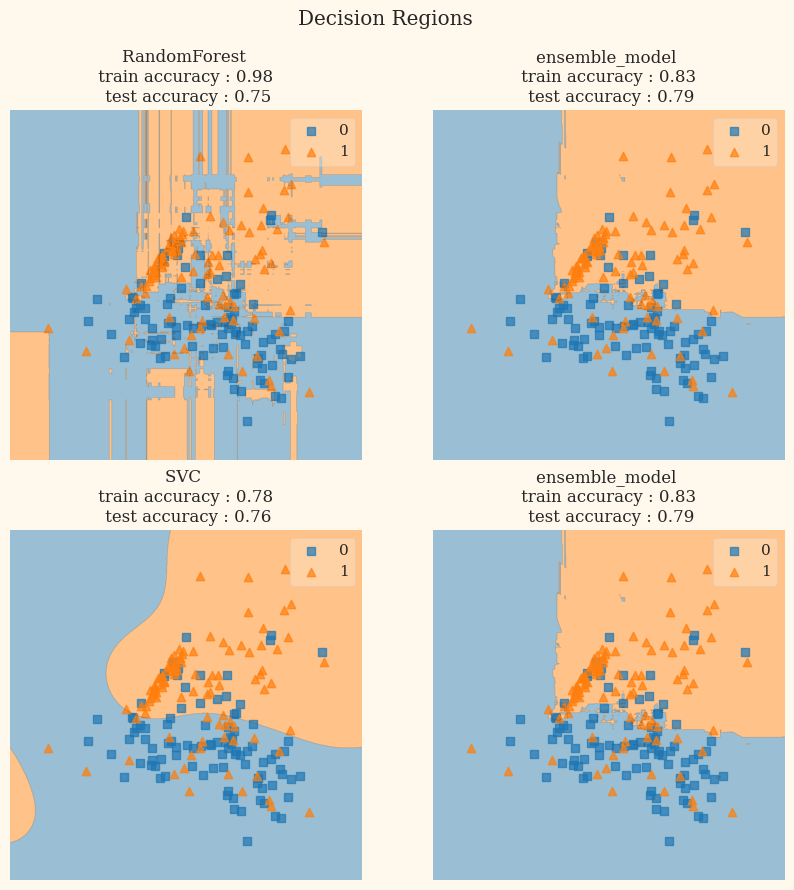

In [12]:
fig,ax = plt.subplots(ncols = 2, nrows = 2, figsize = (10,10))
ax = ax.flatten()

models_name = ['RandomForest','ensemble_model','SVC','ensemble_model']



for i,model in enumerate([rf,ensemble_model,svc, ensemble_model]):
        
    train_score,test_score = train_test_score(model, x_train,y_train,x_test,y_test)
    
    plot_decision_regions(x_test,y_test,clf = model, ax = ax[i],
                            scatter_kwargs = scatter_kwargs, 
                            contour_kwargs = contourf_kwargs)
    
    ax[i].set_title(f'{models_name[i]} \n train accuracy : {train_score} \n test accuracy : {test_score}')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

    
fig.suptitle('Decision Regions')

* 복잡성이 높은 XGBoost 모델에 비해 일반화가 되어 1사분면 부분에서 Positive (1) 부분을 잘 맞추고 있는 모습을 볼 수 있다.
* 복잡성이 낮은 SVC 모델에 비해 복잡성을 높혀 조금 더 세심하게 Negative (0) 부분을 잘 맞추고 있는 모습을 볼 수 있다. 

# 가중치를 둔 Ensemble 

In [14]:
class WeightedEnsembleModel:
    
    def __init__(self,models, splits, random_state):
        
        self.models = models
        self.fitted_models = []
        self.weight_list = [0 for _ in range(len(self.models))]
        self.normalized_list = [0 for _ in range(len(self.models))]
        self.splits = splits
        self.cv = KFold(n_splits = splits, random_state = random_state,
                        shuffle = True)
        
    def fit(self,X,y):
        
        self.X = X
        self.y = y
        
        for i,model in enumerate(self.models):    
            for train_idx,test_idx in self.cv.split(self.X,self.y):
                
                x_train,y_train = self.X[train_idx],self.y[train_idx]
                x_valid,y_valid = self.X[test_idx], self.y[test_idx]
                
                model.fit(x_train,y_train)
                pred = model.predict(x_valid)
                self.weight_list[i] += accuracy_score(y_valid, pred) / self.splits
                

        total_weight = np.sum(self.weight_list)
        
        for i,w in enumerate(self.weight_list):
            
            self.normalized_list[i] += w / total_weight
            

        self.fitted_models = [model.fit(self.X,self.y) for model in models]
        

        
    def predict(self,test):
                
        probas = [model.predict_proba(test)[:,1] * self.normalized_list[i] for i,model in enumerate(self.fitted_models)]
        
        ensemble_pred = (np.sum(probas,axis = 0) > 0.5).astype(int) 
        return ensemble_pred

In [15]:
weighted_ensemble = WeightedEnsembleModel(models, splits = 5, random_state = 42)

Text(0.5, 1.1, 'Deicision Region')

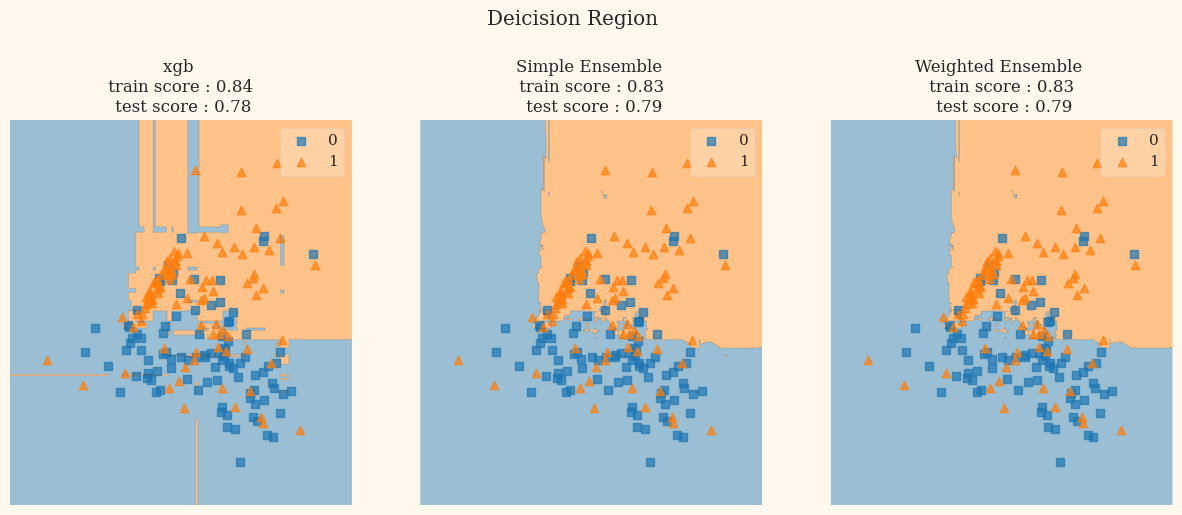

In [16]:
fig,ax = plt.subplots(ncols = 3, figsize = (15,5))

xgb_train_score,xgb_test_score = train_test_score(xgb,x_train,y_train,x_test,y_test)
plot_decision_regions(x_test,y_test,clf = xgb,
                        scatter_kwargs = scatter_kwargs,
                        contour_kwargs = contourf_kwargs,
                        ax = ax[0])
ax[0].set_title(f'xgb \n train score : {xgb_train_score} \n test score : {xgb_test_score}')
ax[0].set_xticks([])
ax[0].set_yticks([])

esb_train_score,esb_test_score = train_test_score(ensemble_model,x_train,y_train,x_test,y_test)
plot_decision_regions(x_test,y_test,clf = ensemble_model,
                        scatter_kwargs = scatter_kwargs,
                        contour_kwargs = contourf_kwargs,
                        ax = ax[1])
ax[1].set_title(f'Simple Ensemble \n train score : {esb_train_score} \n test score : {esb_test_score}')
ax[1].set_xticks([])
ax[1].set_yticks([])

weigted_esb_train_score,weigted_esb_test_score = train_test_score(weighted_ensemble, x_train,y_train,x_test,y_test)
plot_decision_regions(x_test,y_test,clf = weighted_ensemble,
                        scatter_kwargs = scatter_kwargs,
                        contour_kwargs = contourf_kwargs,
                        ax = ax[2])
ax[2].set_title(f'Weighted Ensemble \n train score : {weigted_esb_train_score} \n test score : {weigted_esb_test_score}')
ax[2].set_xticks([])
ax[2].set_yticks([])

fig.suptitle('Deicision Region', y = 1.1)

In [17]:
weighted_ensemble.normalized_list # 모델 별 가중치가 크게 차이 나지 않아 단순 평균을 낸 겻과 큰 차이가 없는 것으로 보인다 

[0.16386206896551722,
 0.16937931034482756,
 0.16689655172413792,
 0.1710344827586207,
 0.17048275862068965,
 0.1583448275862069]